In [1]:
import pandas as pd
import numpy as np
import statistics

import sys
sys.path.append('../scripts')
import recommender as rc

import matplotlib.pyplot as plt

In [2]:
# Dataset loading
data_dir = '../ml-latest-small'

df_movies = pd.read_csv(f"{data_dir}/movies.csv")
df_ratings = pd.read_csv(f"{data_dir}/ratings.csv")

'''
  Create a pandas df with a column for each value of the df[column_name] column (in this case reppresenting the movieId).
  In this example, each row reppresents the ratings given by a user to the specific movie (NaN means rating unknown).
'''
df_user_based_cf = df_ratings.groupby('userId').apply(lambda x: x.set_index('movieId')['rating']).unstack(fill_value=np.nan)

In [3]:
def calculate_satisfaction(group_recommendations, users_recommendations):
    satisfaction = []

    for user_idx, user_recommendations in enumerate(users_recommendations):
        ul_sat = sum(recommendation[0] for recommendation in user_recommendations)
        gl_sat = sum(group_pred[2][user_idx] for group_pred in group_recommendations)

        satisfaction.append(gl_sat/ul_sat)

    return satisfaction


def apply_satisfaction_detection(recommendations, satisfaction):
    for recommendation in recommendations:
        users_predictions = recommendation[2]
        predictions_weighted = np.array(users_predictions) * (np.array(satisfaction) ** 2)
        recommendation[3] = rc.apply_disagreement_detection(predictions_weighted, recommendation[3])

    recommendations.sort(key=lambda x: x[3], reverse=True)


def get_sequential_recommendations(
        df, group, neighbourhood_size=50, predictions_size=10, group_predictions_size=500, sequence=3,
        disagreement_detection=False, satisfaction_detection=True, group_score_function=rc.average_aggregation):

    if disagreement_detection:
        recommendations = rc.get_group_recommendation_with_disagreements(df, group, neighbourhood_size, group_predictions_size, group_predictions_size, group_score_function)
    else:
        recommendations = rc.get_group_recommendation(df, group, neighbourhood_size, group_predictions_size, group_score_function=group_score_function)
    # Get user top predictions
    users_recommendations = [rc.get_predictions(df, target_user, neighbourhood_size, predictions_size) for target_user in group]

    if satisfaction_detection:
        for recommend in recommendations:
            recommend.append(recommend[0])

    # Reset predictions scores (order is kept as already computed).
    for recommend in recommendations:
        recommend[0] = group_score_function(recommend[2])

    recommendation_sequence = []
    for _ in range(sequence):
        if len(recommendations) < predictions_size:
            break

        sequence_predictions = recommendations[:predictions_size]

        satisfaction = calculate_satisfaction(sequence_predictions, users_recommendations)
        recommendation_sequence.append([satisfaction, sequence_predictions])

        # Remove top-k predicted items
        recommendations = recommendations[predictions_size:]

        if satisfaction_detection:
            apply_satisfaction_detection(recommendations, satisfaction)

    return recommendation_sequence

In [4]:
# AI generated code
def plot_2d_column_graph(ax, data):
    x = np.arange(1, len(data) + 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    for i in range(len(data)):
        ax.bar(x[i], data[i], width=0.3, align='center', color=colors[i])

    average_value = np.mean(data)
    ax.axhline(y=average_value, color='red', linestyle='--')

    diff = np.max(data) - np.min(data)
    ax.errorbar(np.mean(x), average_value, yerr=diff, fmt='o', color='black')

    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel('Satisfaction')
    ax.set_title(f'AVG: {rc.float_approx(np.mean(data))} - DIFF: {rc.float_approx(diff)}')

def print_satisfaction_trend(sequence_recommendations):
    num_plots = len(sequence_recommendations)
    num_rows = (num_plots + 4) // 5

    fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4*num_rows))

    for i, recommendation in enumerate(sequence_recommendations):
        row = i // 5
        col = i % 5
        ax = axes[row, col] if num_rows > 1 else axes[col]
        satisfaction = recommendation[0]
        plot_2d_column_graph(ax, satisfaction)

    if num_plots % 5 != 0:
        for j in range(num_plots % 5, 5):
            axes[-1, j].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
def print_sequence_recommendations(sequence_recommendations):
    for iteration, recommendation in enumerate(sequence_recommendations):
        satisfaction = recommendation[0]
        predictions = recommendation[1]

        avg = float(rc.float_approx(statistics.mean(satisfaction)))
        diff = float(rc.float_approx(max(satisfaction) - min(satisfaction)))

        print(f"Iteration: {iteration}")
        print(f"Satisfactions: [{rc.float_list_approx(satisfaction)}]\tAvg: {avg}\tDiff: {diff}\tA-D: {rc.float_approx(avg-diff)}")
        print("Predictions:")
        rc.print_group_predictions(predictions)
        print()

In [6]:
group = rc.random_distinct_indexes(df_user_based_cf, 5)
satisfaction_detection  = get_sequential_recommendations(df_user_based_cf, group, sequence=5, disagreement_detection=False, satisfaction_detection=True)
no_detection            = get_sequential_recommendations(df_user_based_cf, group, sequence=5, disagreement_detection=False, satisfaction_detection=False)
disagreement_detection  = get_sequential_recommendations(df_user_based_cf, group, sequence=5, disagreement_detection=True, satisfaction_detection=False)
sat_and_dis_detection   = get_sequential_recommendations(df_user_based_cf, group, sequence=5, disagreement_detection=True, satisfaction_detection=True)

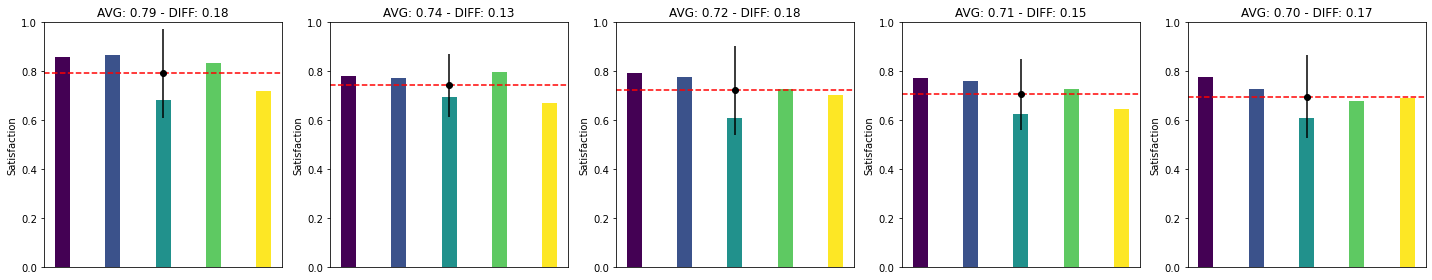

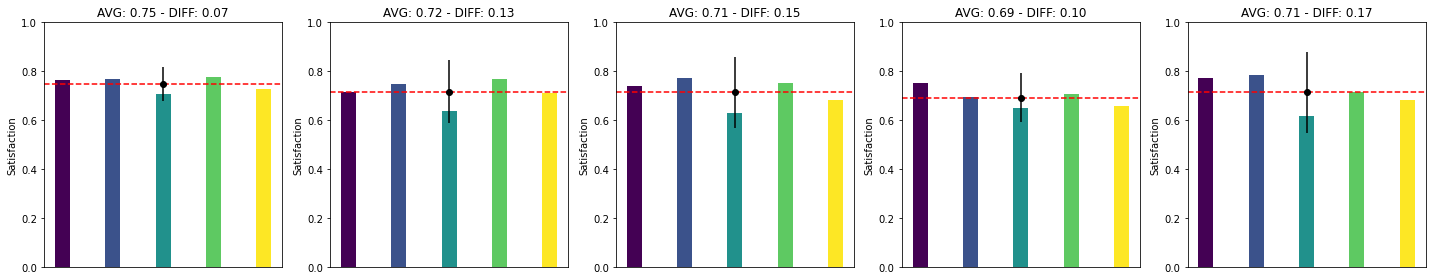

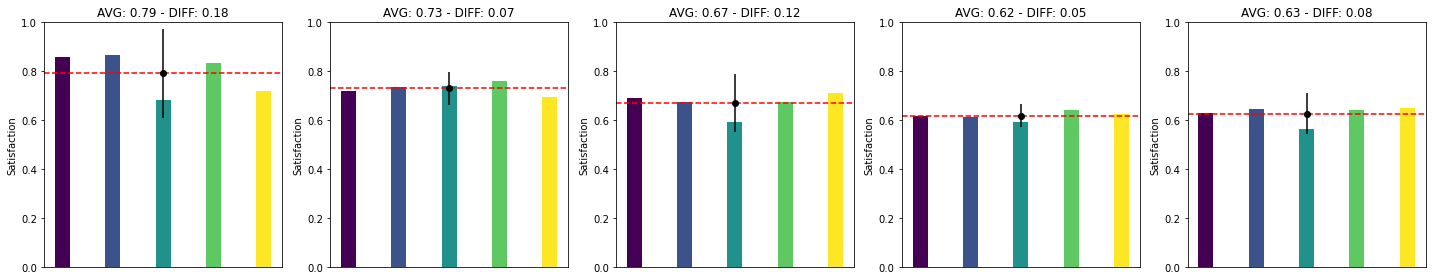

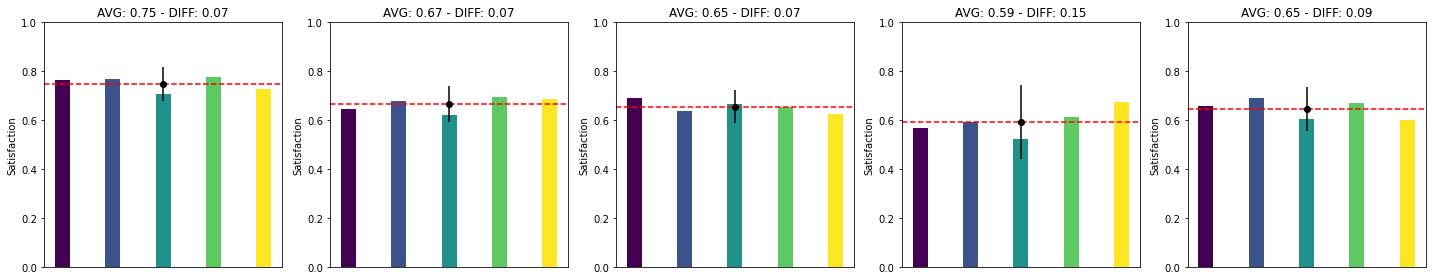

In [7]:
print_satisfaction_trend(no_detection)
print_satisfaction_trend(disagreement_detection)
print_satisfaction_trend(satisfaction_detection)
print_satisfaction_trend(sat_and_dis_detection)

In [8]:
print_sequence_recommendations(satisfaction_detection)

Iteration: 0
Satisfactions: [0.86, 0.87, 0.68, 0.83, 0.72]	Avg: 0.79	Diff: 0.18	A-D: 0.61
Predictions:
Movie ID: 1204	Score: [4.66]	 Users' Predictions: [5.46, 5.71, 4.06, 4.52, 3.54]
Movie ID: 3972	Score: [4.6]	 Users' Predictions: [5.03, 5.65, 3.36, 4.98, 3.96]
Movie ID: 3471	Score: [4.41]	 Users' Predictions: [5.46, 5.01, 4.47, 4.59, 2.54]
Movie ID: 2542	Score: [4.31]	 Users' Predictions: [5.58, 5.28, 2.96, 4.31, 3.42]
Movie ID: 898 	Score: [4.24]	 Users' Predictions: [4.68, 3.99, 4.07, 4.98, 3.46]
Movie ID: 265 	Score: [4.2]	 Users' Predictions: [4.04, 4.59, 4.40, 3.92, 4.03]
Movie ID: 750 	Score: [4.19]	 Users' Predictions: [4.52, 5.09, 3.46, 4.32, 3.56]
Movie ID: 1959	Score: [4.11]	 Users' Predictions: [3.85, 4.71, 4.06, 3.97, 3.97]
Movie ID: 1276	Score: [4.11]	 Users' Predictions: [4.43, 4.99, 3.25, 4.12, 3.75]
Movie ID: 5060	Score: [4.09]	 Users' Predictions: [4.54, 4.40, 3.57, 4.36, 3.56]
AVG: [4.29]	ST-DEV: [0.20]	DIFF: [0.57]

Iteration: 1
Satisfactions: [0.72, 0.74, 0.74, 0

In [11]:
def get_scores(sequence_recommendations):
    predictions_scores = []

    for recommendation in sequence_recommendations:
        predictions = recommendation[1]

        scores = []
        for prediction in predictions:
            scores.append(prediction[0])
        predictions_scores.append(scores)

    return predictions_scores

# AI Generated code
def plot_line_graph(users_data, colors, legend_names):
    for user, color, legend_name in zip(users_data, colors, legend_names):
        average_data = [sum(data_point)/len(data_point) for data_point in zip(*user)]
        x_values = [i for i in range(len(average_data))]
        plt.plot(x_values, average_data, color=color, label=legend_name)

        # Plot average line
        plt.plot(x_values, [sum(average_data)/len(average_data)]*len(x_values), linestyle='--', color=color)

    plt.title('Average Group Score per Sequence')
    plt.ylabel('Score')
    plt.grid(True)
    plt.xticks([])
    plt.ylim(3, 5)
    plt.legend()
    plt.show()

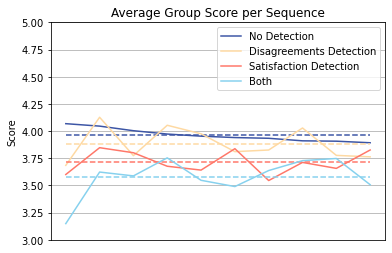

In [12]:
scores = [get_scores(sequences) for sequences in [no_detection, disagreement_detection, satisfaction_detection, sat_and_dis_detection]]

plot_line_graph(
    scores,
    ['#3c55a5', '#fed9a2', '#ff7769', '#86d1ee'],
    ['No Detection', 'Disagreements Detection', 'Satisfaction Detection', 'Both'])